
### 02_data_analysis.ipynb
```markdown
# 02_data_analysis.ipynb

## Notebook Purpose
This notebook is designed to perform exploratory data analysis (EDA) on the preprocessed cryptocurrency data. It will generate visualizations to help understand the data, identify trends, and detect any patterns.

## Instructions
1. **Import Necessary Libraries**:
   - Import `pandas` for data manipulation.
   - Import `matplotlib` and `seaborn` for data visualization.

2. **Load Preprocessed Data**:
   - Load the preprocessed CSV file created in the previous notebook.

3. **Plot Closing Prices**:
   - Generate a plot showing the closing prices over time to observe overall trends.

4. **Plot Technical Indicators**:
   - Generate plots for the calculated technical indicators (e.g., SMA, EMA) to visualize their behavior over time.

5. **Correlation Analysis**:
   - Calculate and visualize the correlation matrix to understand relationships between different features.

## Example Code

```
python
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
data_path = 'data/historical_data/btc_usd_preprocessed.csv'  # Update this path based on the selected cryptocurrency
data = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

# Plot closing price over time
plt.figure(figsize=(14, 7))
plt.plot(data['Close'])
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

# Plot technical indicators
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close')
plt.plot(data['SMA_20'], label='SMA 20')
plt.plot(data['SMA_50'], label='SMA 50')
plt.title('Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Display correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

```

In [16]:
# Import necessary libraries
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    print("Libraries imported successfully.")
except ImportError as e:
    print(f"Error importing libraries: {e}")


Libraries imported successfully.


In [17]:
# Function to load data for multiple cryptocurrencies
def load_crypto_data(cryptos, years):
    data_frames = {}
    for crypto in cryptos:
        yearly_data = []
        
        # Load data from CryptoCompare (yearly files)
        for year in years:
            try:
                df = pd.read_csv(f'../data/historical_data/{crypto}_cryptocompare_{year}.csv')
                if 'time' in df.columns:
                    df.rename(columns={'time': 'date'}, inplace=True)
                    df['date'] = pd.to_datetime(df['date'])
                    df.set_index('date', inplace=True)
                print(f"Loaded {crypto} data from CryptoCompare for year {year}")
                print(df.head())  # Show the format of the data
                yearly_data.append(df)
            except FileNotFoundError:
                print(f"Data for {crypto} in year {year} from CryptoCompare not found.")
        
        # Load data from Alpha Vantage
        try:
            av_df = pd.read_csv(f'../data/historical_data/{crypto}_alpha_vantage.csv')
            if 'time' in av_df.columns:
                av_df.rename(columns={'time': 'date'}, inplace=True)
                av_df['date'] = pd.to_datetime(av_df['date'])
                av_df.set_index('date', inplace=True)
            print(f"Loaded {crypto} data from Alpha Vantage")
            print(av_df.head())  # Show the format of the data
            yearly_data.append(av_df)
        except FileNotFoundError:
            print(f"Data for {crypto} from Alpha Vantage not found.")
        
        # Load data from Coinbase
        try:
            cb_df = pd.read_csv(f'../data/historical_data/{crypto}_coinbase.csv')
            if 'time' in cb_df.columns:
                cb_df.rename(columns={'time': 'date'}, inplace=True)
                cb_df['date'] = pd.to_datetime(cb_df['date'])
                cb_df.set_index('date', inplace=True)
            print(f"Loaded {crypto} data from Coinbase")
            print(cb_df.head())  # Show the format of the data
            yearly_data.append(cb_df)
        except FileNotFoundError:
            print(f"Data for {crypto} from Coinbase not found.")
        
        # Concatenate all data frames for the crypto
        if yearly_data:
            data_frames[crypto] = pd.concat(yearly_data)
    
    return data_frames

# Load the data
cryptos = ["BTC", "ETH", "SOL"]
years = range(2018, 2024)
crypto_data = load_crypto_data(cryptos, years)

print("Data loaded successfully for the following cryptocurrencies:")
for crypto in crypto_data:
    print(f"- {crypto}: {crypto_data[crypto].shape[0]} rows")


Loaded BTC data from CryptoCompare for year 2018
             open    high    low  close      volume
date                                               
2013-07-10  76.70   89.84  75.53  88.00  4916740.89
2013-07-11  88.00   90.70  85.00  88.98  3084484.64
2013-07-12  88.98  104.17  88.00  93.99  9759561.48
2013-07-13  93.99   98.32  87.76  98.32  3186590.74
2013-07-14  98.32   99.00  92.86  94.42  1171458.48
Loaded BTC data from CryptoCompare for year 2019
              open    high     low   close      volume
date                                                  
2014-07-10  623.00  624.95  611.66  618.39  2253171.20
2014-07-11  618.39  633.62  616.11  632.90  1969199.34
2014-07-12  632.90  638.59  625.90  635.90  2179286.05
2014-07-13  635.90  638.64  627.54  628.03  1082830.37
2014-07-14  628.03  628.99  616.06  618.32  1601572.72
Loaded BTC data from CryptoCompare for year 2020
              open    high     low   close       volume
date                                            

In [18]:
# Function to check data quality and label bad data
def check_data_quality(df, source):
    print(f"\nChecking data quality for {source} data...")
    
    # Check for missing values
    missing_values = df.isnull().sum()
    print("Missing values:\n", missing_values)
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print("Number of duplicates:", duplicates)
    
    # Identify bad data (for Coinbase, bad data might only have date and price)
    if source == 'Coinbase' and 'close' not in df.columns:
        df['bad_data'] = True
        print("Identified bad data in Coinbase dataset.")
    else:
        df['bad_data'] = False
    
    return df

# Check data quality for each cryptocurrency
for crypto, df in crypto_data.items():
    crypto_data[crypto] = check_data_quality(df, crypto)



Checking data quality for BTC data...
Missing values:
 open       1097
high       1097
low        1097
close      1097
volume     1097
price     12306
dtype: int64
Number of duplicates: 9275

Checking data quality for ETH data...
Missing values:
 open       1097
high       1097
low        1097
close      1097
volume     1097
price     12306
dtype: int64
Number of duplicates: 10032

Checking data quality for SOL data...
Missing values:
 open       1097
high       1097
low        1097
close      1097
volume     1097
price     12306
dtype: int64
Number of duplicates: 11505


In [19]:
# Function to handle missing values and duplicates
def clean_data(df):
    # Fill missing values (forward fill for time series data)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    
    # Drop duplicates
    df.drop_duplicates(inplace=True)
    
    return df

# Separate bad data and clean good data
cleaned_data = {}
bad_data = {}
for crypto, df in crypto_data.items():
    original_shape = df.shape
    
    # Separate bad data
    bad_df = df[df['bad_data'] == True]
    good_df = df[df['bad_data'] == False]
    
    # Clean good data
    good_df = clean_data(good_df)
    
    cleaned_shape = good_df.shape
    cleaned_data[crypto] = good_df
    bad_data[crypto] = bad_df
    
    print(f"\n{crypto} data cleaned.")
    print(f"Original shape: {original_shape}, Cleaned shape: {cleaned_shape}")
    print(f"Number of NaNs after cleaning: {good_df.isnull().sum().sum()}")
    print(f"Number of duplicates after cleaning: {good_df.duplicated().sum()}")
    print(f"Number of bad data points: {bad_df.shape[0]}")



BTC data cleaned.
Original shape: (13403, 7), Cleaned shape: (4127, 7)
Number of NaNs after cleaning: 0
Number of duplicates after cleaning: 0
Number of bad data points: 0

ETH data cleaned.
Original shape: (13403, 7), Cleaned shape: (3370, 7)
Number of NaNs after cleaning: 0
Number of duplicates after cleaning: 0
Number of bad data points: 0

SOL data cleaned.
Original shape: (13403, 7), Cleaned shape: (1897, 7)
Number of NaNs after cleaning: 0
Number of duplicates after cleaning: 0
Number of bad data points: 0


In [20]:
# Function to save cleaned data and bad data to new folders
def save_data(cleaned_data, bad_data, clean_folder_path, bad_folder_path):
    os.makedirs(clean_folder_path, exist_ok=True)
    os.makedirs(bad_folder_path, exist_ok=True)
    
    for crypto, df in cleaned_data.items():
        df.to_csv(f'{clean_folder_path}/{crypto}_cleaned.csv')
        print(f"Saved cleaned data for {crypto} to {clean_folder_path}/{crypto}_cleaned.csv")
    
    for crypto, df in bad_data.items():
        if not df.empty:
            df.to_csv(f'{bad_folder_path}/{crypto}_bad.csv')
            print(f"Saved bad data for {crypto} to {bad_folder_path}/{crypto}_bad.csv")

# Save cleaned data and bad data
save_data(cleaned_data, bad_data, '../data/cleaned_data', '../data/bad_data')


Saved cleaned data for BTC to ../data/cleaned_data/BTC_cleaned.csv
Saved cleaned data for ETH to ../data/cleaned_data/ETH_cleaned.csv
Saved cleaned data for SOL to ../data/cleaned_data/SOL_cleaned.csv


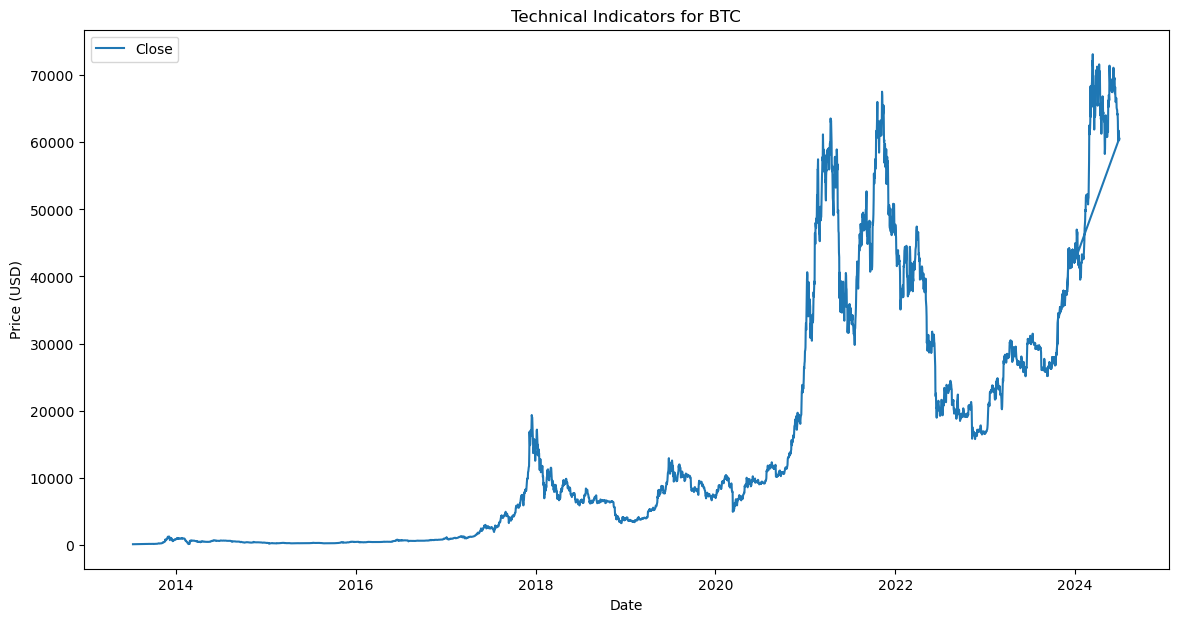

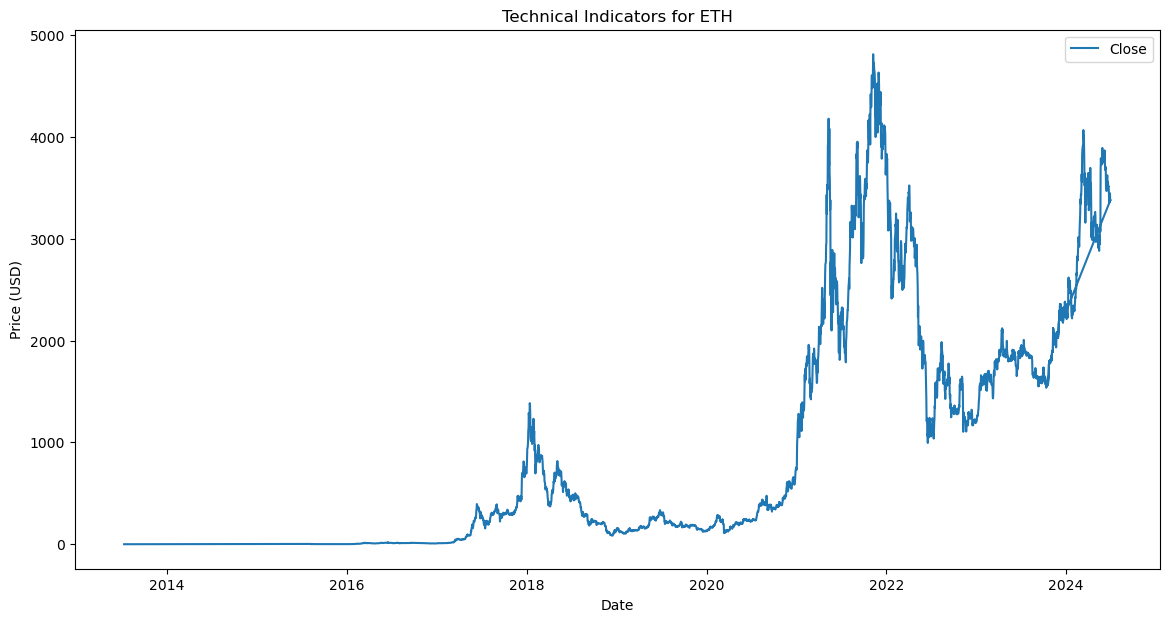

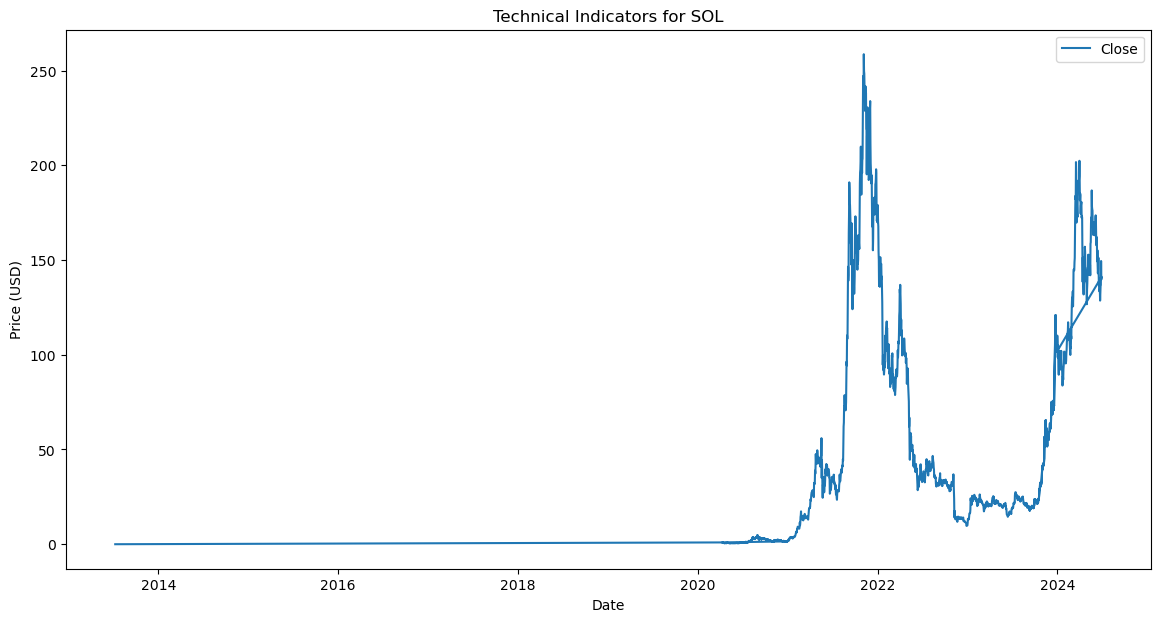

In [21]:
# Function to plot closing prices and technical indicators
def plot_technical_indicators(df, crypto):
    plt.figure(figsize=(14, 7))
    plt.plot(df['close'], label='Close')
    if 'SMA_20' in df.columns:
        plt.plot(df['SMA_20'], label='SMA 20')
    if 'SMA_50' in df.columns:
        plt.plot(df['SMA_50'], label='SMA 50')
    plt.title(f'Technical Indicators for {crypto}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

# Plot data for each cryptocurrency
for crypto, df in cleaned_data.items():
    plot_technical_indicators(df, crypto)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


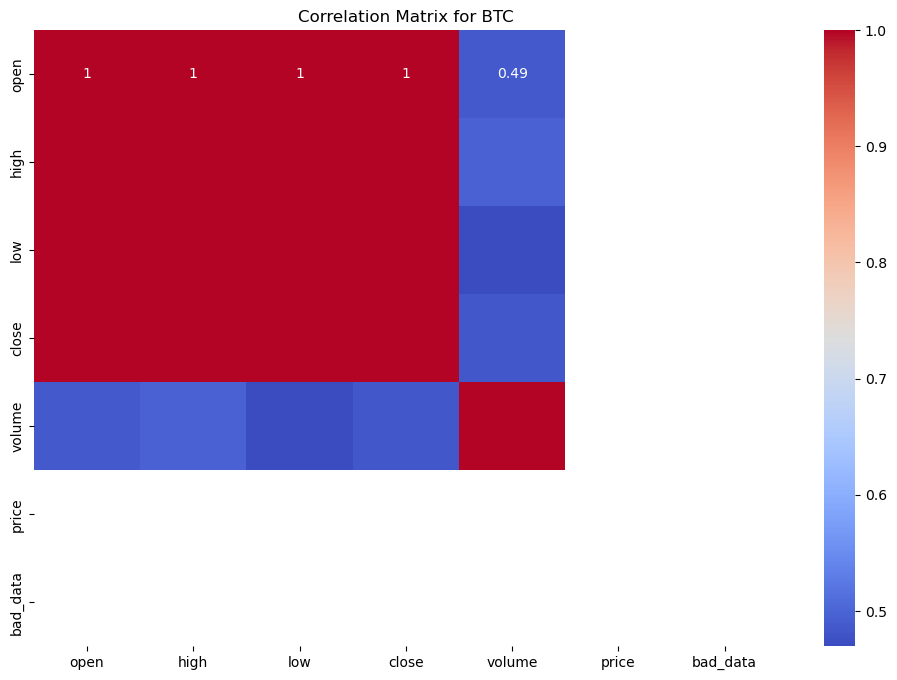

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


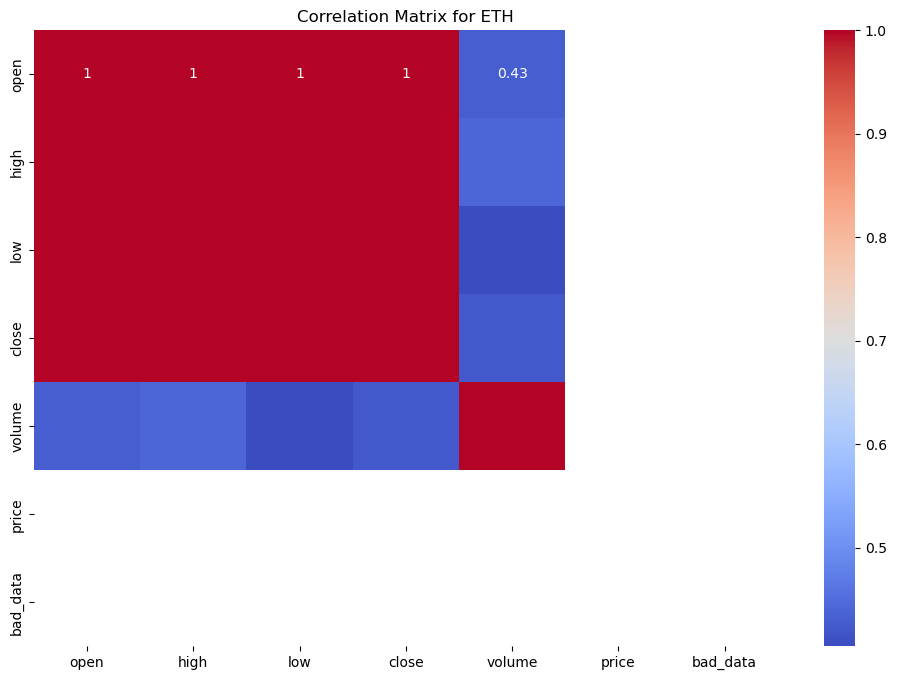

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


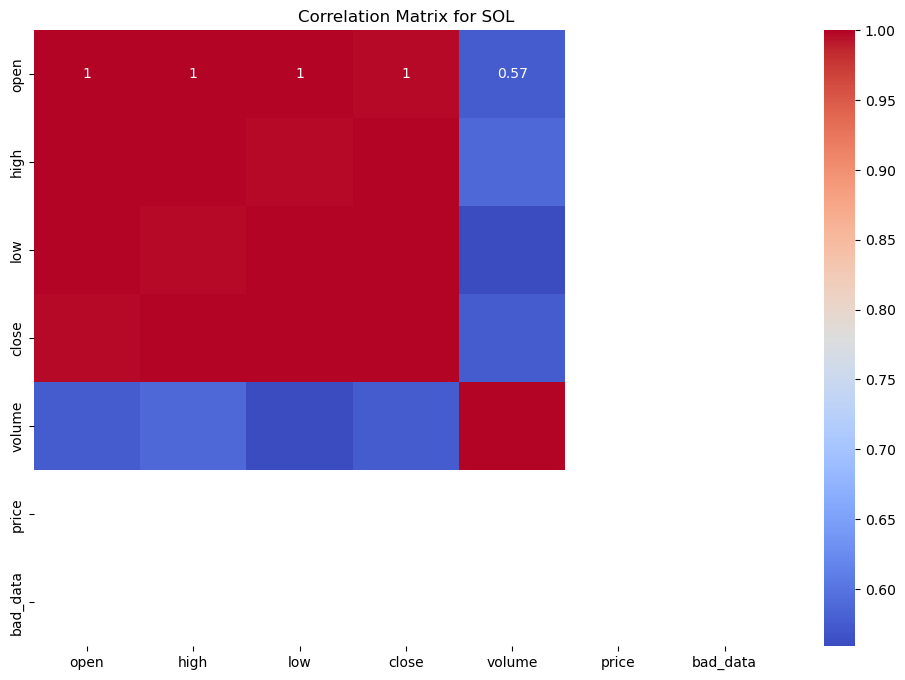

In [22]:
# Function to display correlation matrix
def plot_correlation_matrix(df, crypto):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix for {crypto}')
    plt.show()

# Plot correlation matrix for each cryptocurrency
for crypto, df in cleaned_data.items():
    plot_correlation_matrix(df, crypto)
